In [1]:
import os
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
from scipy.integrate import trapz, quad
import time
from scipy.special import erf

In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_notimeout_GKM.txt"
pcCatalog = "koiCatalogs/dr25_GKM_PCs_notimeout.csv"

period_rng = (1, 500)
n_period = 101
rp_rng = (2.5, 5)
n_rp = 101

whichRadii = "corrected"
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string')

In [3]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois

In [4]:
period = np.logspace(np.log10(1), np.log10(500), num=10)
rp = np.logspace(np.log10(2.5), np.log10(5), num=5)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
periodShape = period_grid.shape

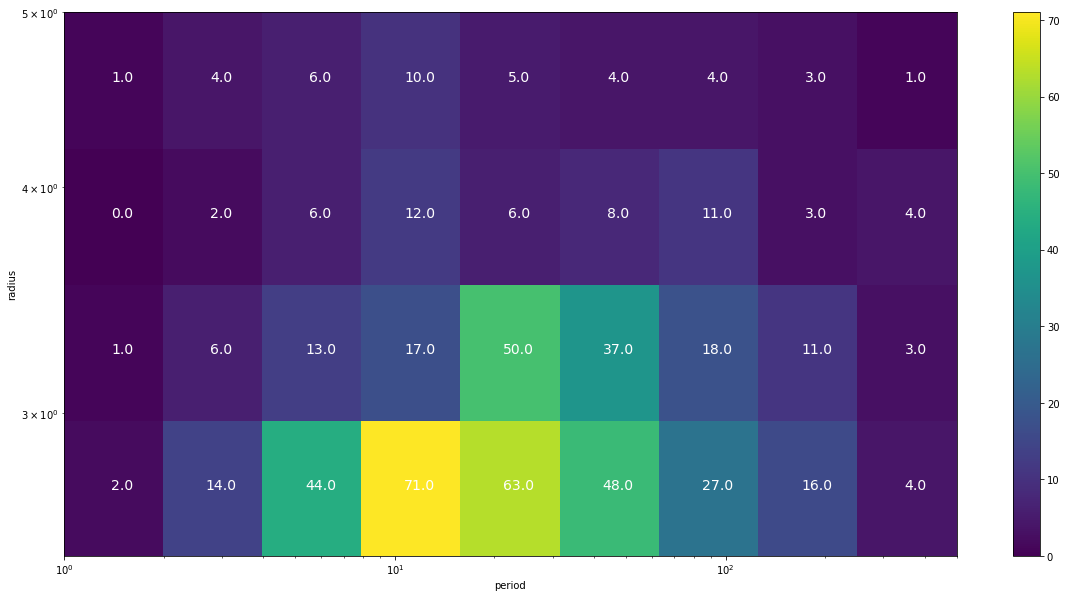

In [5]:
H, xedges, yedges = np.histogram2d(kois.koi_period, getRadii(kois), bins=(period, rp))
xcent = 0.5 * (xedges[1:] + xedges[:-1])
ycent = 0.5 * (yedges[1:] + yedges[:-1])

fig, ax = plt.subplots(figsize=(20, 10))
im = ax.pcolormesh(period_grid, rp_grid, H)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], H.T[i,j], 
                color="white", ha="center", va="center", fontsize=14)

plt.xlabel('period')
plt.ylabel('radius')
plt.xscale('log')
plt.yscale('log')
fig.colorbar(im)
plt.show()

In [6]:
inputgrid = "../completenessContours/out0702_sc0_GKM_baseline.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
print(hdulist[0].header,)

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
numProbDetInterp = RectBivariateSpline(period_want, rp_want, probdet)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 1000                                                  NAXIS2  =                 1000                                                  NAXIS3  =                    2                                                  EXTEND  =                    T                                                  MINPER  =                  1.0                                                  MAXPER  =                500.0                                                  NPER    =                 1000                                                  MINRP   =                  1.7                                                  MAXRP   =                  6.0                                                  NRP     =                 1000          

In [7]:
len(cumulative_array)

2

In [8]:
summedCompleteness = numCompVeInterp(period, rp)
summedProbDet = numProbDetInterp(period, rp)

In [9]:
from scipy.interpolate import griddata
points = np.array(list(zip(period_grid.flatten(), rp_grid.flatten())))
values = summedCompleteness.flatten()

pc = np.array(list(zip(kois.koi_period.values, getRadii(kois).values)))

grid = griddata(points, values, pc, method='linear')

In [10]:
kois['completeness'] = grid/ kiclist.size
kois['kois_rp'] = getRadii(kois)

In [11]:
np.ones

<function numpy.ones(shape, dtype=None, order='C')>

In [12]:
occ = np.zeros((len(period)-1, len(rp)-1))
w = np.zeros((len(period)-1, len(rp)-1))
u = np.zeros((len(period)-1, len(rp)-1))

for i in range(len(period)-1):
    for j in range(len(rp)-1):
        bin_ = kois[((kois.koi_period < period[i+1]) & (kois.koi_period > period[i]) & 
                     (kois.kois_rp < rp[j+1]) & (kois.kois_rp > rp[j]))]
        occ[i, j] = np.sum(bin_.totalReliability / bin_.completeness)/kiclist.size
        
        w[i, j] = trapz(trapz(summedProbDet[i:i+2, j:j+2]/kiclist.size, dx=1), dx=1)
        u[i, j] = trapz(trapz(summedCompleteness[i:i+2, j:j+2]/kiclist.size, dx=1), dx=1)

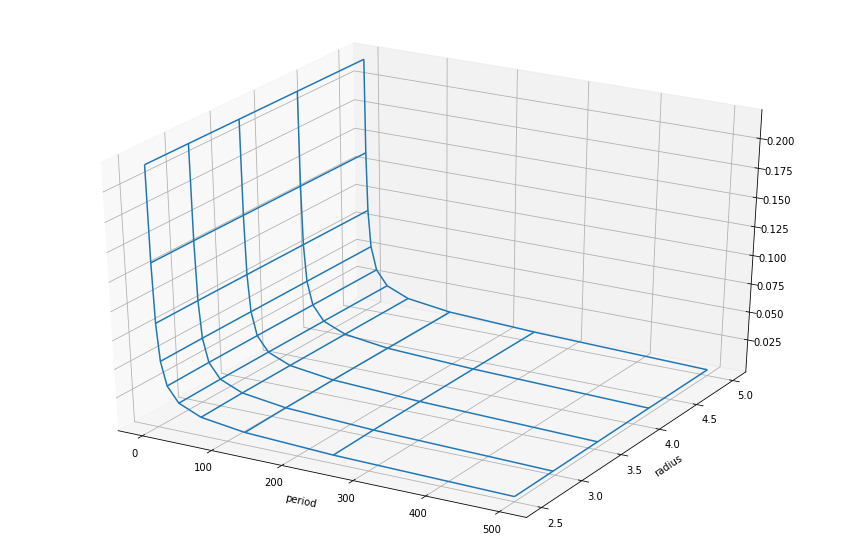

In [24]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(period_grid, rp_grid, summedCompleteness / kiclist.size)
#ax.plot_wireframe(period_grid, rp_grid, summedProbDet/ kiclist.size)
ax.set_xlabel('period')
ax.set_ylabel('radius')
plt.show()

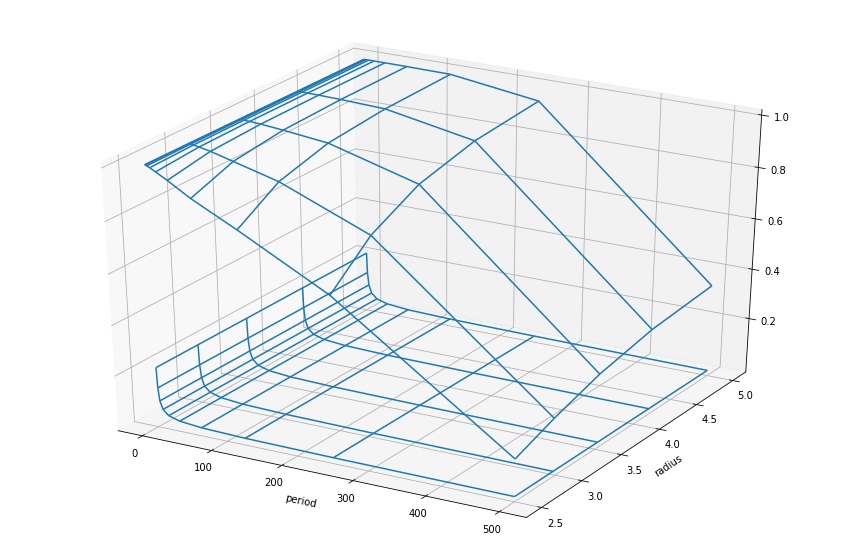

In [13]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(period_grid, rp_grid, summedCompleteness / kiclist.size)
ax.plot_wireframe(period_grid, rp_grid, summedProbDet/ kiclist.size)
ax.set_xlabel('period')
ax.set_ylabel('radius')
plt.show()

In [14]:
c = np.zeros((len(period)-1, len(rp)-1))
H[H == 0.0] = -0.999
occ_upper = occ.copy()
c[H < 0] = 1
summedCompleteness_c = 0.5*(summedCompleteness[1:, 1:] + summedCompleteness[:-1, :-1])
occ_upper[occ == 0.] = 1 / summedCompleteness_c[np.where(occ == 0.)]

weighted_occ = occ_upper / w

weighted_occ

array([[2.01586266e-04, 1.13076771e-04, 9.61646259e-05, 1.17774185e-04],
       [2.28080897e-03, 8.92115254e-04, 3.41831169e-04, 6.76823103e-04],
       [1.04416343e-02, 2.96003836e-03, 1.35765997e-03, 1.34112569e-03],
       [2.69354574e-02, 6.30246948e-03, 3.52488584e-03, 3.43427610e-03],
       [3.75303150e-02, 2.89600359e-02, 2.93432046e-03, 2.92383675e-03],
       [4.86716307e-02, 3.33906362e-02, 4.75511477e-03, 2.67426124e-03],
       [4.82641031e-02, 2.87887838e-02, 1.32064467e-02, 4.77033546e-03],
       [5.87462289e-02, 2.96307808e-02, 7.01104035e-03, 7.54836405e-03],
       [4.97878794e-02, 6.00087050e-02, 3.40890496e-02, 2.75869519e-03]])

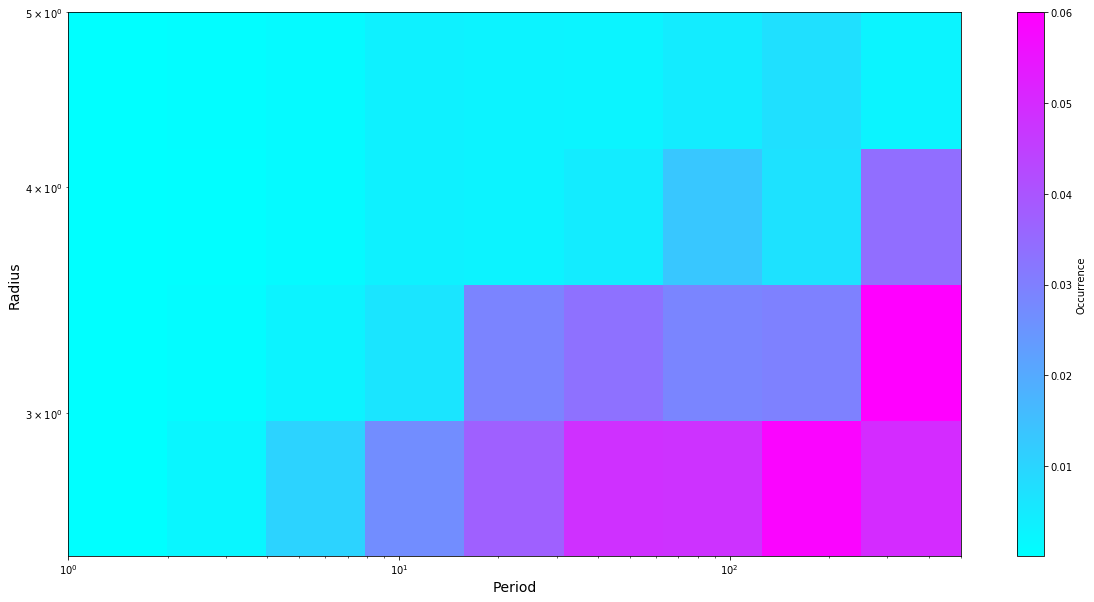

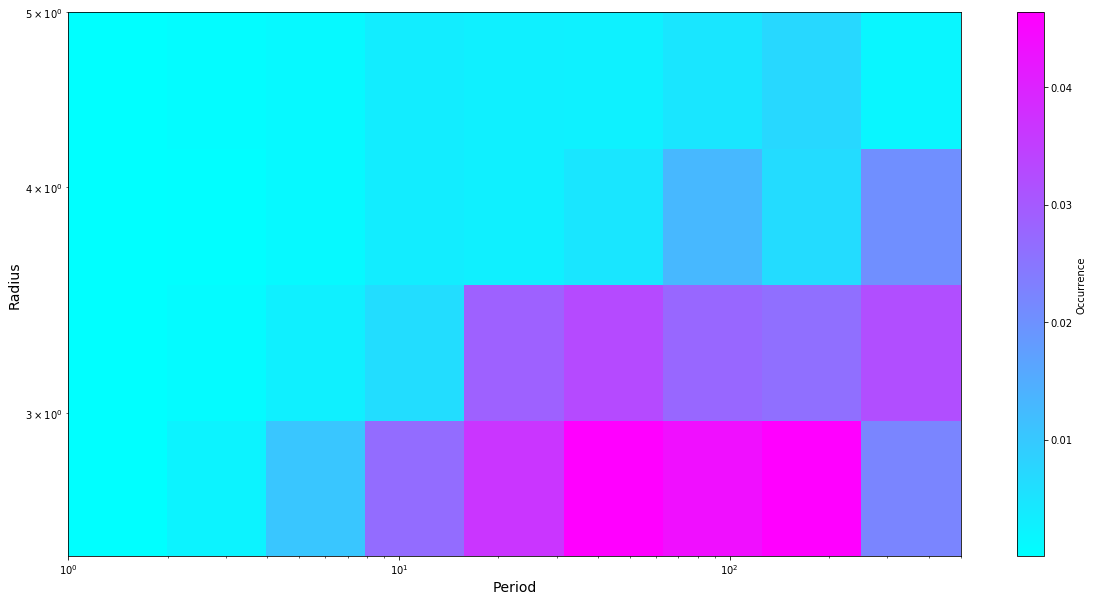

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
im = ax.pcolormesh(period_grid, rp_grid, weighted_occ, cmap='cool')
plt.colorbar(im, label="Occurrence")
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')

fig, ax = plt.subplots(figsize=(20, 10))
im = ax.pcolormesh(period_grid, rp_grid, occ_upper, cmap='cool')
plt.colorbar(im, label="Occurrence")
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')


plt.show()

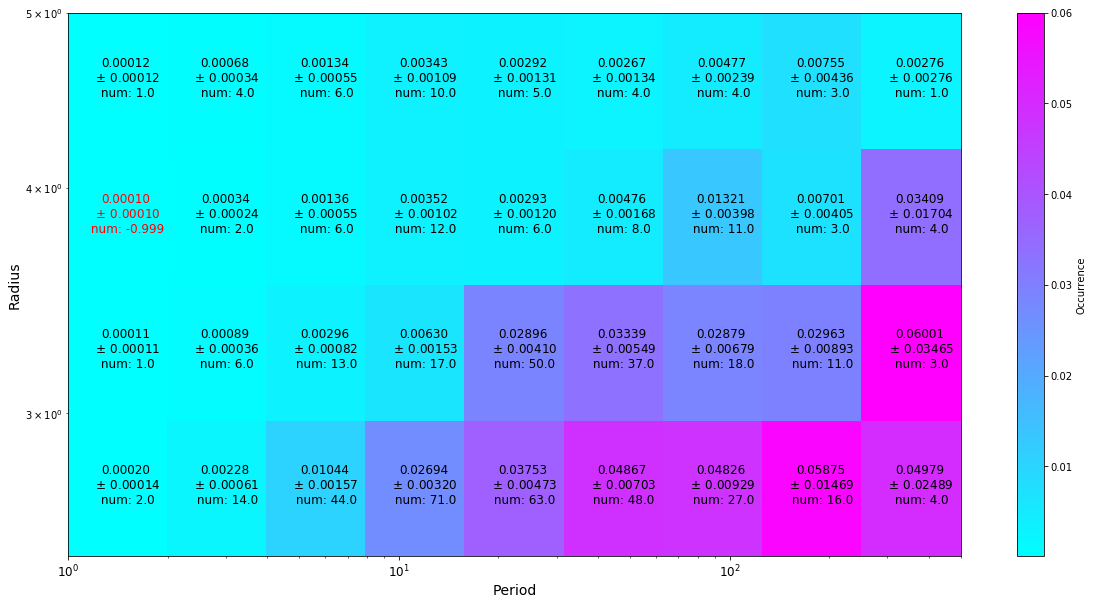

In [16]:
exp = weighted_occ * kiclist.size
err = np.sqrt(np.abs(H)) * exp / (kiclist.size * np.abs(H))

fig, ax = plt.subplots(figsize=(20, 10))
im = ax.pcolormesh(period_grid, rp_grid, weighted_occ, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        t = str("%.5f" % weighted_occ.T[i,j]) + '\n' + r" $\pm$ " + str("%.5f" % err.T[i,j]) + '\n num: ' + str(H.T[i,j])
        if H.T[i,j]<0:
            ax.text(xcent[j], ycent[i], t, 
                color="r", ha="center", va="center", fontsize=12)
        else:
            ax.text(xcent[j], ycent[i], t, 
                color="k", ha="center", va="center", fontsize=12)

ax.tick_params(axis='both', labelsize='large')
               
plt.colorbar(im, label="Occurrence")
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')

plt.show()

In [17]:
co_period = np.empty(np.sum(c, axis=1).shape, dtype=str)
co_period[np.sum(c, axis=1) == 0] = 'k'
co_period[np.sum(c, axis=1) >= 1.] = 'r'

co_rad = np.empty(np.sum(c, axis=0).shape, dtype=str)
co_rad[np.sum(c, axis=0) == 0] = 'k'
co_rad[np.sum(c, axis=0) >= 1.] = 'r'

p_cent = 0.5* (period[1:] + period[:-1])
r_cent = 0.5* (rp[1:] + rp[:-1])

err2 = err**2

In [18]:
occ_total = occ_upper / u
err_total = (np.sqrt(np.abs(H)) * occ_total * kiclist.size) / (kiclist.size * np.abs(H))
err_total2 = err_total**2

u

array([[0.17910046, 0.17914907, 0.17915487, 0.1791556 ],
       [0.11306428, 0.1131695 , 0.11318717, 0.11318921],
       [0.07121953, 0.07140563, 0.07144882, 0.07145529],
       [0.04470858, 0.04499584, 0.04507798, 0.04509525],
       [0.02788234, 0.02828432, 0.02841708, 0.02845281],
       [0.01713269, 0.01766716, 0.01787303, 0.01793987],
       [0.0102425 , 0.01088609, 0.01117812, 0.0112887 ],
       [0.00572017, 0.00639157, 0.00676861, 0.00694708],
       [0.00225193, 0.00269062, 0.00299585, 0.00317285]])

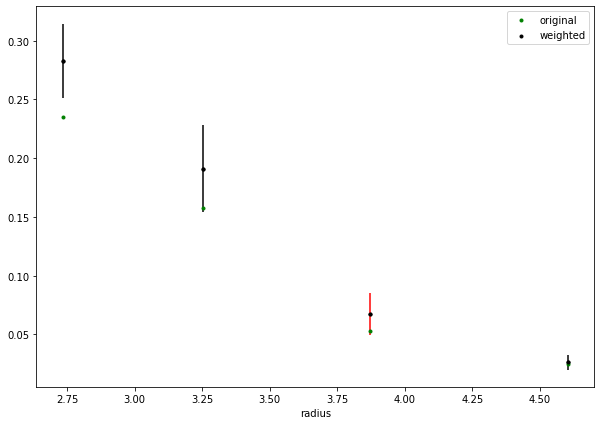

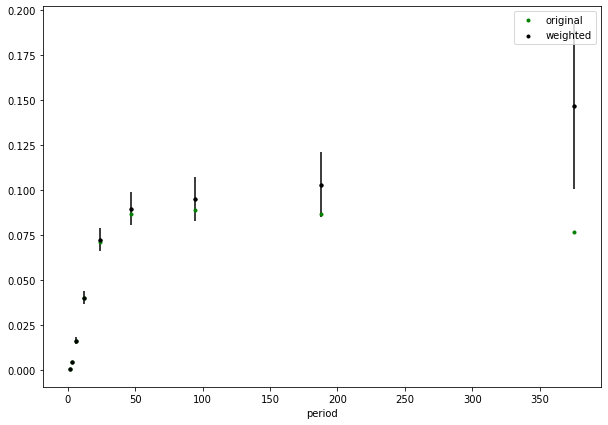

In [19]:
plt.figure(figsize=(10, 7))
plt.plot(r_cent, np.sum(occ_upper, axis=0), 'g.', label="original")
plt.scatter(r_cent, np.sum(weighted_occ, axis=0), marker='.', color='k', label="weighted")
plt.errorbar(r_cent, np.sum(weighted_occ, axis=0), yerr=np.sqrt(np.sum(err2, axis=0)), fmt='k.', ecolor=co_rad)
#plt.errorbar(r_cent, np.sum(occ_total, axis=0), yerr=np.sqrt(np.sum(err_total2, axis=0)),
#             fmt='b.', ecolor=co_rad, label="total completeness")
plt.xlabel("radius")
plt.legend()

plt.figure(figsize=(10, 7))
plt.plot(p_cent, np.sum(occ_upper, axis=1), 'g.', label="original")
plt.scatter(p_cent, np.sum(weighted_occ, axis=1), marker='.', color='k', label="weighted")
plt.errorbar(p_cent, np.sum(weighted_occ, axis=1), yerr=np.sqrt(np.sum(err2, axis=1)), fmt='k.', ecolor=co_period)
#plt.errorbar(p_cent, np.sum(occ_total, axis=1), yerr=np.sqrt(np.sum(err_total2, axis=1)),
#             fmt='b.', ecolor=co_rad, label="total completeness")
plt.xlabel("period")
plt.legend()

plt.show()

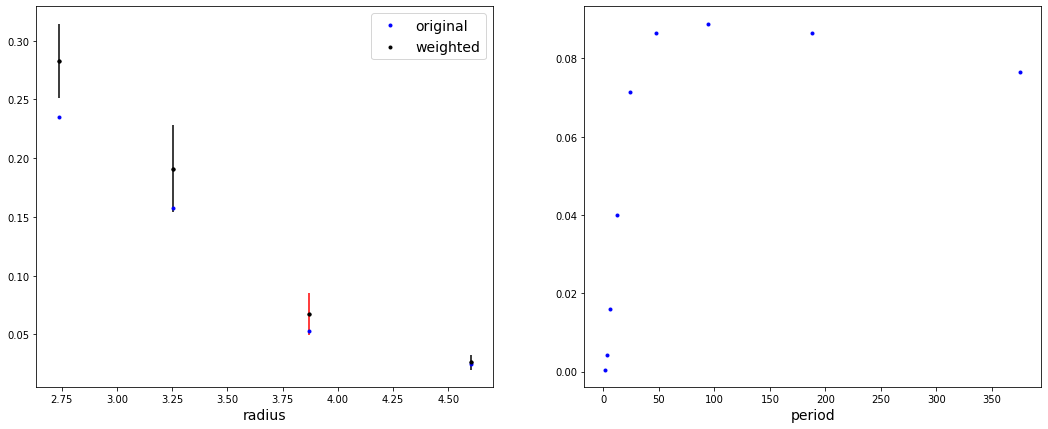

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

axs[0].plot(r_cent, np.sum(occ_upper, axis=0), 'b.', label="original")
axs[0].scatter(r_cent, np.sum(weighted_occ, axis=0), marker='.', color='k', label="weighted")
axs[0].errorbar(r_cent, np.sum(weighted_occ, axis=0), yerr=np.sqrt(np.sum(err2, axis=0)), fmt='k.', ecolor=co_rad)
#axs[0].errorbar(r_cent, np.sum(occ_total, axis=0), yerr=np.sqrt(np.sum(err_total2, axis=0)),
#             fmt='b.', ecolor=co_rad, label="total completeness")
axs[0].set_xlabel("radius", fontsize=14)
axs[0].legend(fontsize=14)

axs[1].plot(p_cent, np.sum(occ_upper, axis=1), 'b.', label="original")
#axs[1].scatter(p_cent, np.sum(weighted_occ, axis=1), marker='.', color='k', label="weighted")
#axs[1].errorbar(p_cent, np.sum(weighted_occ, axis=1), yerr=np.sqrt(np.sum(err2, axis=1)), fmt='k.', ecolor=co_period)
#axs[1].errorbar(p_cent, np.sum(occ_total, axis=1), yerr=np.sqrt(np.sum(err_total2, axis=1)),
#             fmt='b.', ecolor=co_rad, label="total completeness")
axs[1].set_xlabel("period", fontsize=14)
#axs[1].legend(loc=2, fontsize=14)

plt.show()